In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path

import pytorch_lightning as pl
import yaml
from torch.utils.data import DataLoader
from transformers import set_seed

from datasets.class_writer import CSVWriter
from datasets.class_dataset import CSVDataset
from models._old_deroberta_model import PretrainedDeRoBertaClass as OldPretrainedDeRoBertaClass
from models.deroberta_model import PretrainedDeRoBertaClass
from utils.metrics import Statistics
from utils.log_reader import TensorBoardReader

set_seed(42)

In [3]:
# Config initialisation
data_config = yaml.load(open("configs/multi_data_config.yaml", 'r'), Loader=yaml.Loader)
deberta_model_config = yaml.load(open("configs/deberta_model_config.yaml", 'r'), Loader=yaml.Loader)
roberta_model_config = yaml.load(open("configs/roberta_model_config.yaml", 'r'), Loader=yaml.Loader)

In [4]:
# Data processing
val_dataset = CSVDataset(data_config["validate_data_path"],
                         is_uncased=data_config["is_uncased"],
                         pretrained_tokenizer="microsoft/mdeberta-v3-base",
                         max_length=data_config["max_token_number"])
val_dataloader = DataLoader(val_dataset, shuffle=False,
                            batch_size=data_config["batch_size"], drop_last=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Этап 1
Сначала было рассмотрено самое популярное решение среди участников: fine-tuning модели DeBERTa для классификации текстов.
В качестве pooling-а выхода модели было использовано взятие скрытого состояния первого токена.
Результат проецировался с помощью ReLU и линейного слоя.

Для обучения использовался оптимизатор AdamW вместе с OneCycle планировщиком, линейно изменяющий learning rate.  
Первые 10% шагов происходит стадия разогрева с увеличением learning rate, который также должен уменьшить искажение предзагруженных весов на первых шагах при обучении случайно инициализированного последнего слоя.  
Оставшееся время learning rate постепенно уменьшается для более точных шагов.

In [5]:
# Getting path to the last checkpoint
t_reader = TensorBoardReader(Path(deberta_model_config["log_dir"]) / Path("lightning_logs"))
path_to_checkpoint = t_reader.get_ckpt_path(1)

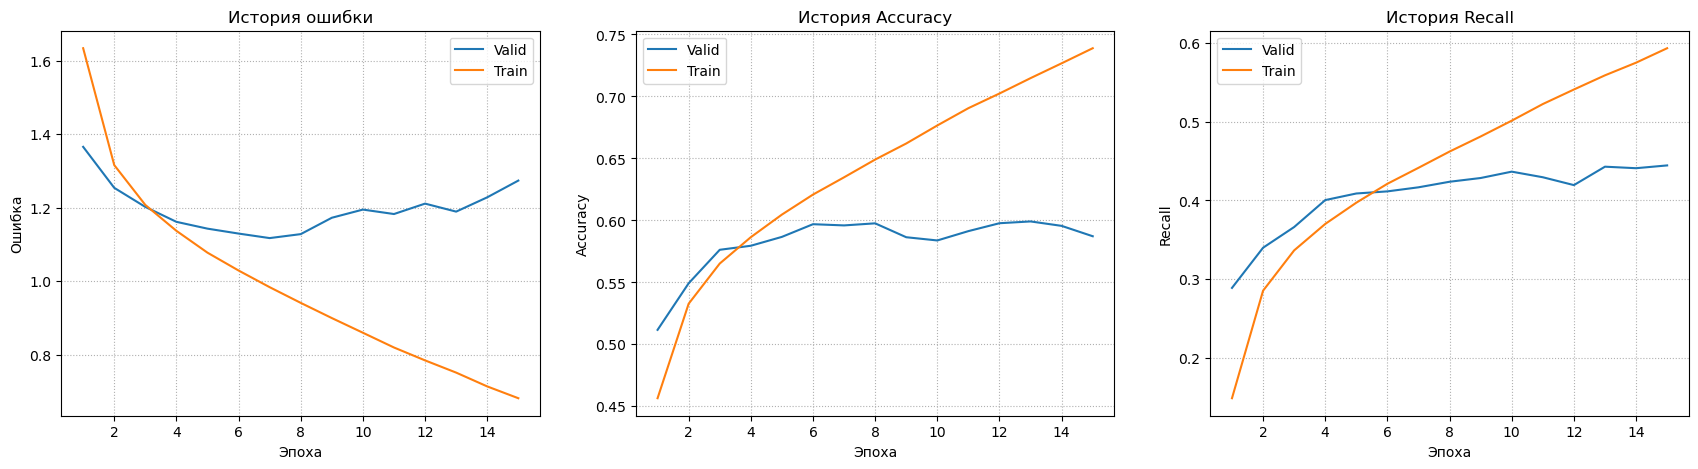

In [6]:
# Training visualisation
t_reader.plot_tensorboard_graphics(1)

In [7]:
# Pytorch lightning
deberta_model = OldPretrainedDeRoBertaClass.load_from_checkpoint(path_to_checkpoint)
print(deberta_model)
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(deberta_model, val_dataloader)

Some weights of the model checkpoint at microsoft/mdeberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'deberta.embeddings.word_embeddings._weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSeque

PretrainedDeRoBertaClass(
  (model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(250102, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (dropo

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_acc', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5990513563156128
       test_recall          0.4427665174007416
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.5990513563156128, 'test_recall': 0.4427665174007416}]

                     precision    recall  f1-score   support

              Human     0.8251    0.8384    0.8317      8521
             M-BART     0.5250    0.6547    0.5827       417
           M-BART50     0.5068    0.4476    0.4754      1986
            M2M-100     0.2886    0.4226    0.3430      1803
            OPUS-MT     0.3721    0.3704    0.3712      2014
          mT5-Large     0.3852    0.2506    0.3037       810
          mT5-Small     0.5325    0.4184    0.4686       490
       ruGPT2-Large     0.6489    0.5848    0.6152       395
       ruGPT3-Large     0.5209    0.5000    0.5102      1644
      ruGPT3-Medium     0.4897    0.4077    0.4450      1170
       ruGPT3-Small     0.5351    0.6473    0.5859      1154
          ruT5-Base     0.6441    0.6909    0.6667       440
ruT5-Base-Multitask     0.3731    0.1351    0.1984       370
         ruT5-Large     0.2762    0.1000    0.1468       290

           accuracy                         0.5991     21504
          macro avg   

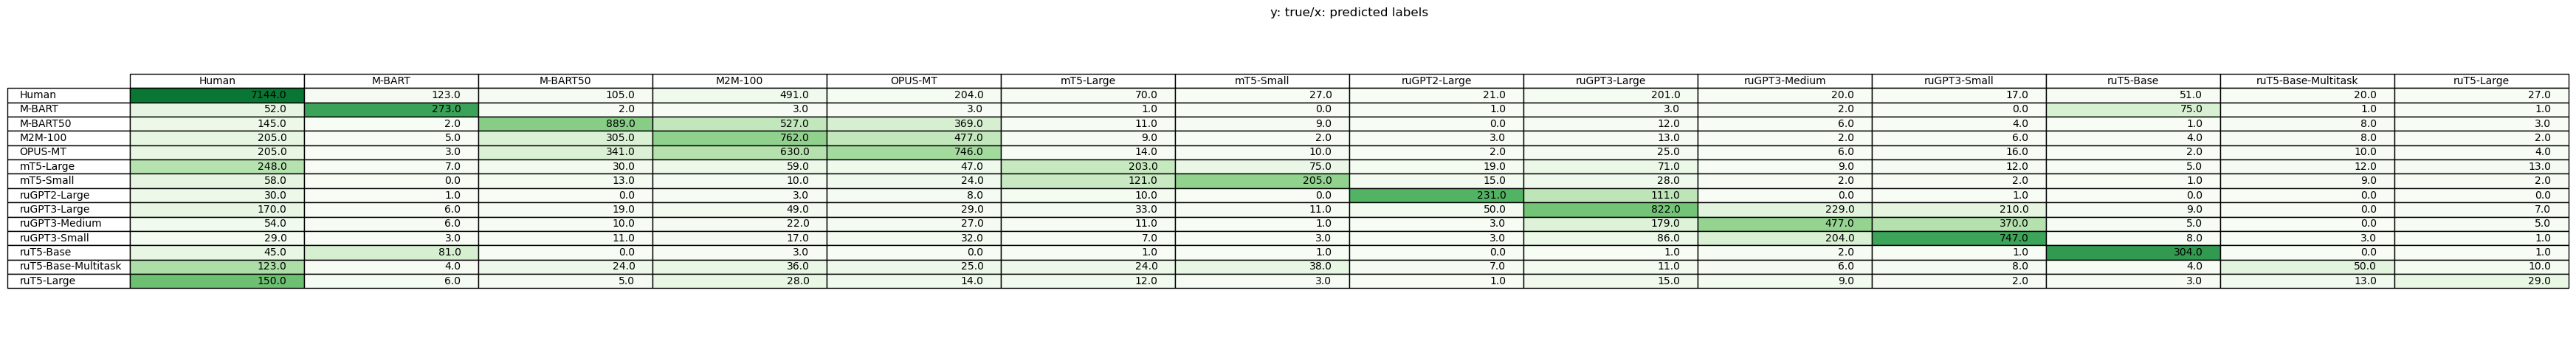

Wrongly predicted examples:
| Record id: | Sentence:                                                                                                                                                                                                                                                                                                                                                                                                                                                           | True label:  | Pred labels:  |
| 104959     | Он не хотел пугать ее да мужичков.                                                                                                                                                                                                                                                                                                                                                                                                                                  | Hum

In [8]:
# Print metrics
stats = Statistics(deberta_model, val_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

### Этап 2
Чтобы исключить возможность потери информации из DeBERTa в следующем эксперименте был использован AveragePooling для агрегации скрытых состояний всех токенов в один вектор.

In [13]:
# Getting path to the last checkpoint
t_reader = TensorBoardReader(Path(deberta_model_config["log_dir"]) / Path("lightning_logs"))
path_to_checkpoint = t_reader.get_ckpt_path(3)

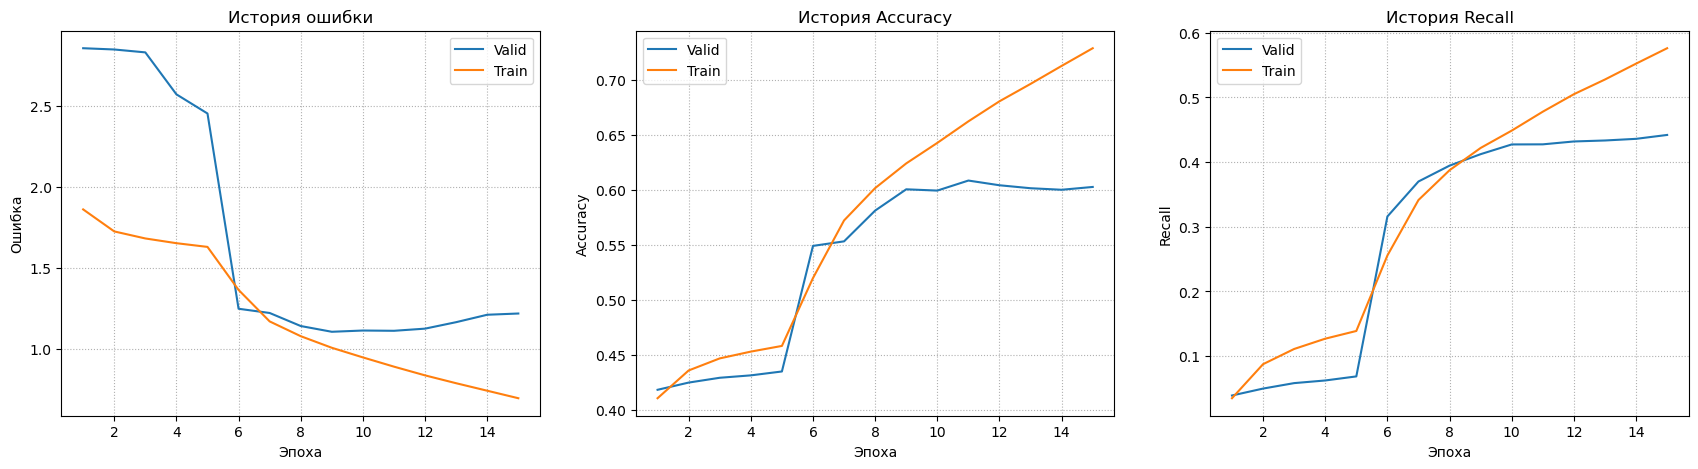

In [14]:
# Training visualisation
t_reader.plot_tensorboard_graphics(3)

In [15]:
# Pytorch lightning
deberta_model = PretrainedDeRoBertaClass.load_from_checkpoint(path_to_checkpoint)
print(deberta_model)
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(deberta_model, val_dataloader)

Some weights of the model checkpoint at microsoft/mdeberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'deberta.embeddings.word_embeddings._weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSeque

PretrainedDeRoBertaClass(
  (model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(250102, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (dropo

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_acc', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6081659197807312
       test_recall          0.4280138909816742
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.6081659197807312, 'test_recall': 0.4280138909816742}]

                     precision    recall  f1-score   support

              Human     0.7906    0.8836    0.8345      8521
             M-BART     0.5067    0.6307    0.5620       417
           M-BART50     0.4510    0.5171    0.4818      1986
            M2M-100     0.3159    0.2512    0.2799      1803
            OPUS-MT     0.3574    0.4369    0.3932      2014
          mT5-Large     0.3587    0.2383    0.2864       810
          mT5-Small     0.5705    0.5122    0.5398       490
       ruGPT2-Large     0.7212    0.5696    0.6365       395
       ruGPT3-Large     0.6085    0.4179    0.4955      1644
      ruGPT3-Medium     0.5107    0.4479    0.4772      1170
       ruGPT3-Small     0.5585    0.6127    0.5843      1154
          ruT5-Base     0.6908    0.5636    0.6208       440
ruT5-Base-Multitask     0.4469    0.2162    0.2914       370
         ruT5-Large     0.2750    0.0379    0.0667       290

           accuracy                         0.6082     21504
          macro avg   

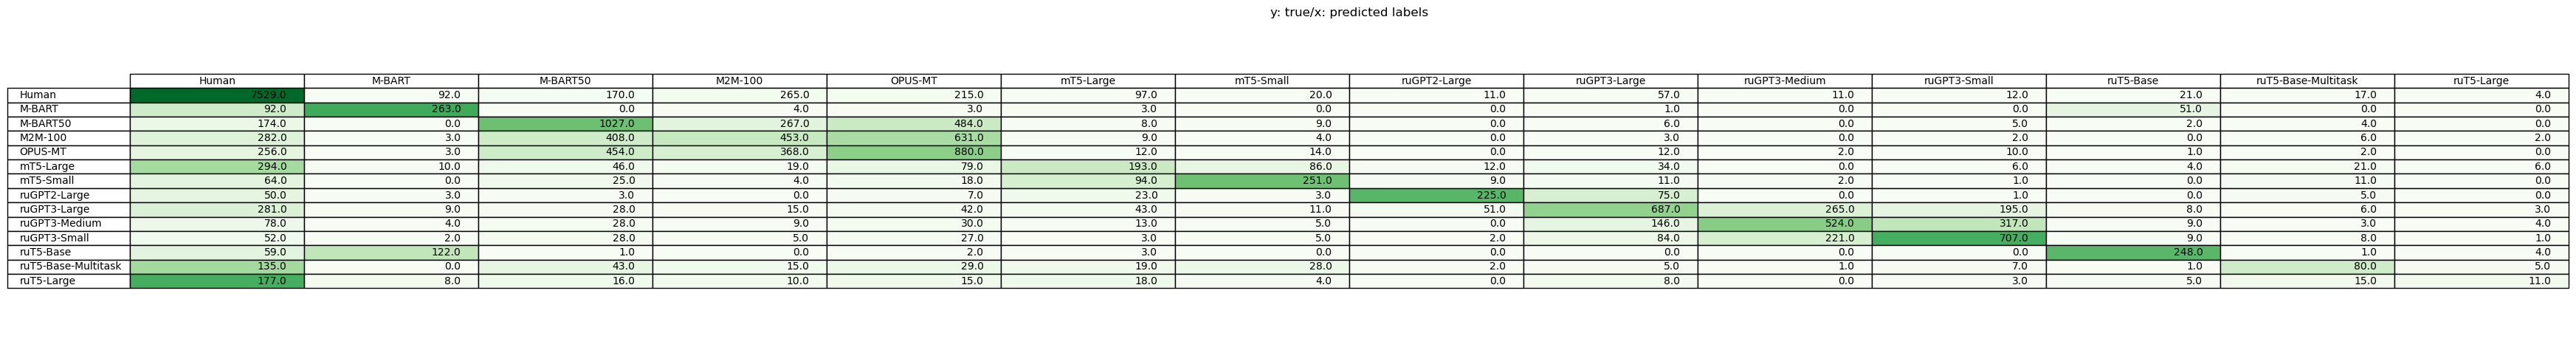

Wrongly predicted examples:
| Record id: | Sentence:                                                                              | True label:         | Pred labels:        |
| 90381      | По мере того как вы движетесь на север и на запад от гор, вероятность дождя снижается. | M-BART50            | M2M-100             |
| 99457      | Всю тревогу Мозгляков заронил в его куриное сердце, исчезла при виде дам.              | ruT5-Base-Multitask | Human               |
| 142605     | Стропальщик должен знать устройство башенного крана.                                   | Human               | OPUS-MT             |
| 159336     | Лучше поздно, чем никогда.                                                             | M-BART50            | M2M-100             |
| 86413      | По радио грозят Литве. Так важно им выстоять. Так важно.                               | Human               | ruT5-Base-Multitask |


In [16]:
# Print metrics
stats = Statistics(deberta_model, val_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

### Этап 3
Как видно, качество модели при использовании AveragePooling увеличилось, поэтому в следующем эксперименте был расширен классифицирующий слой двумя свёрточными слоями с kernel size = 5 и stride = 2 перед AveragePooling, разделёнными функцией активации.  
Чтобы исключить возможность потери знаний из предзагруженных весов, первые пять эпох обучения выделены на адапатацию новых блоков —digits=4 обучение с замороженной предобученной моделью.

In [13]:
# Getting path to the last checkpoint
t_reader = TensorBoardReader(Path(deberta_model_config["log_dir"]) / Path("lightning_logs"))
path_to_checkpoint = t_reader.get_ckpt_path(3)

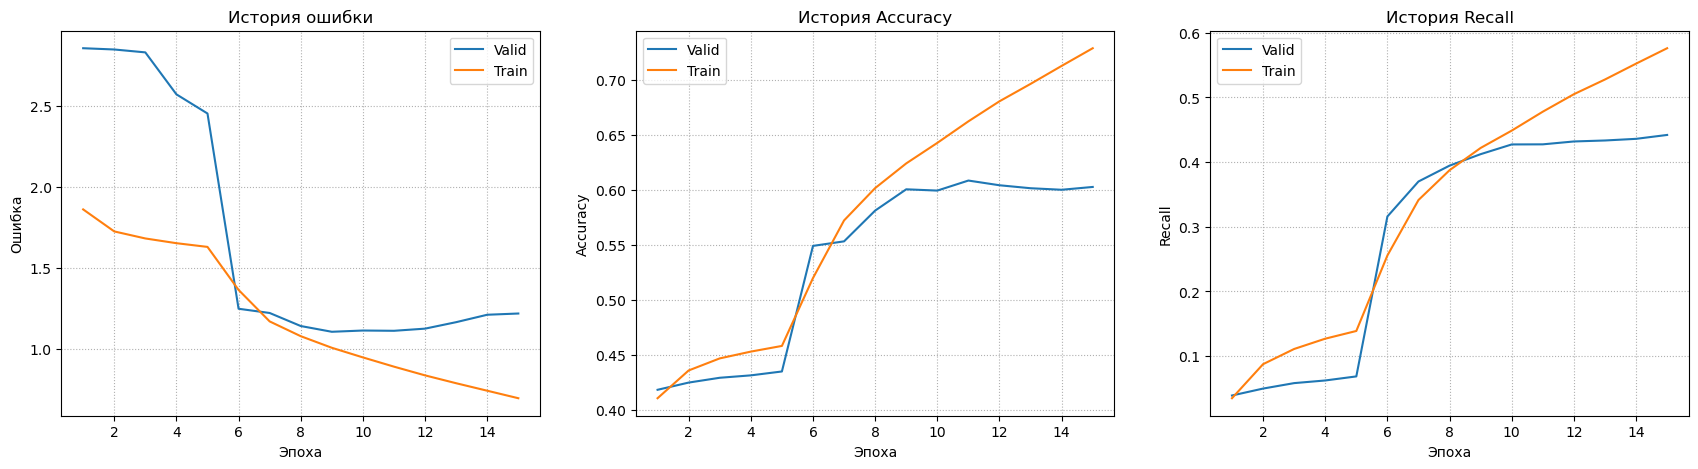

In [14]:
# Training visualisation
t_reader.plot_tensorboard_graphics(3)

In [15]:
# Pytorch lightning
deberta_model = PretrainedDeRoBertaClass.load_from_checkpoint(path_to_checkpoint)
print(deberta_model)
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(deberta_model, val_dataloader)

Some weights of the model checkpoint at microsoft/mdeberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'deberta.embeddings.word_embeddings._weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSeque

PretrainedDeRoBertaClass(
  (model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(250102, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (dropo

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_acc', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6081659197807312
       test_recall          0.4280138909816742
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.6081659197807312, 'test_recall': 0.4280138909816742}]

                     precision    recall  f1-score   support

              Human     0.7906    0.8836    0.8345      8521
             M-BART     0.5067    0.6307    0.5620       417
           M-BART50     0.4510    0.5171    0.4818      1986
            M2M-100     0.3159    0.2512    0.2799      1803
            OPUS-MT     0.3574    0.4369    0.3932      2014
          mT5-Large     0.3587    0.2383    0.2864       810
          mT5-Small     0.5705    0.5122    0.5398       490
       ruGPT2-Large     0.7212    0.5696    0.6365       395
       ruGPT3-Large     0.6085    0.4179    0.4955      1644
      ruGPT3-Medium     0.5107    0.4479    0.4772      1170
       ruGPT3-Small     0.5585    0.6127    0.5843      1154
          ruT5-Base     0.6908    0.5636    0.6208       440
ruT5-Base-Multitask     0.4469    0.2162    0.2914       370
         ruT5-Large     0.2750    0.0379    0.0667       290

           accuracy                         0.6082     21504
          macro avg   

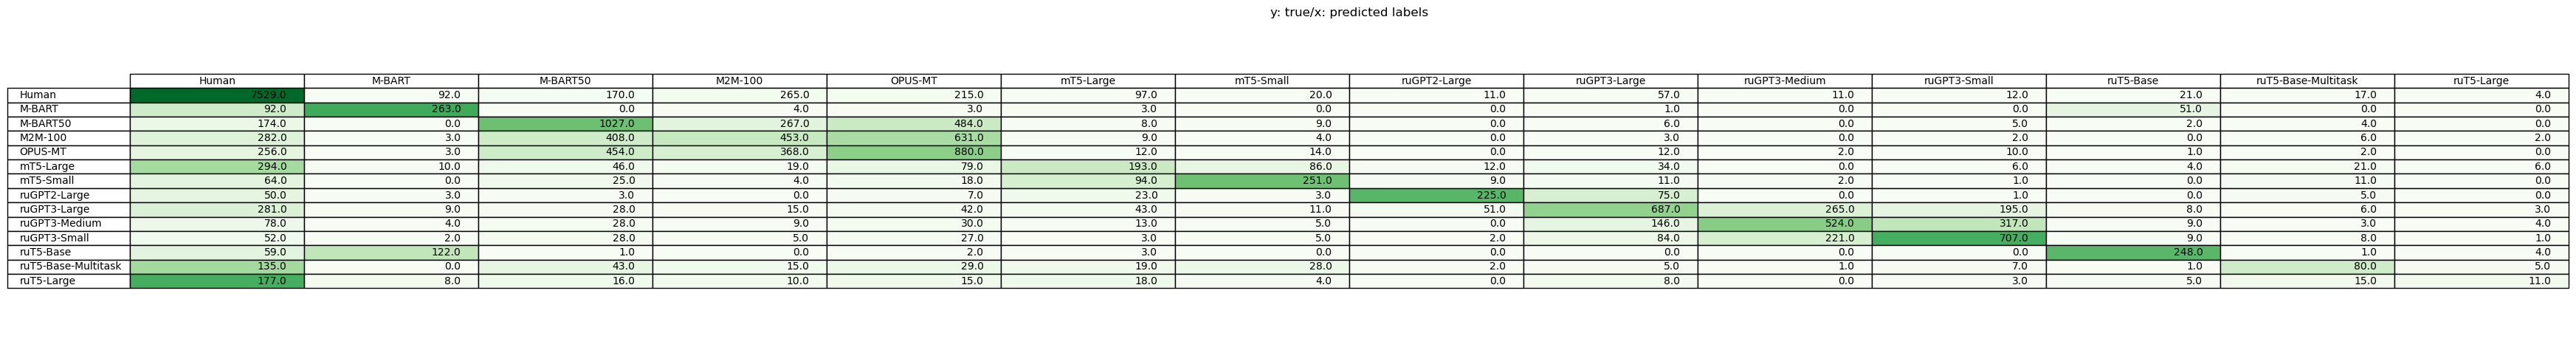

Wrongly predicted examples:
| Record id: | Sentence:                                                                              | True label:         | Pred labels:        |
| 90381      | По мере того как вы движетесь на север и на запад от гор, вероятность дождя снижается. | M-BART50            | M2M-100             |
| 99457      | Всю тревогу Мозгляков заронил в его куриное сердце, исчезла при виде дам.              | ruT5-Base-Multitask | Human               |
| 142605     | Стропальщик должен знать устройство башенного крана.                                   | Human               | OPUS-MT             |
| 159336     | Лучше поздно, чем никогда.                                                             | M-BART50            | M2M-100             |
| 86413      | По радио грозят Литве. Так важно им выстоять. Так важно.                               | Human               | ruT5-Base-Multitask |


In [16]:
# Print metrics
stats = Statistics(deberta_model, val_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

### Этап 4
Последний эксперимент также показал незначительное улучшение метрик.  
Так как используемый DeBERTa является мультиязычной моделью от Microsoft, обученной для 100 языков и протестированной на 16, посмотрим на аналогичные результаты для модели натренированной специально для русского языка — RuRoBERTa от SberDevice.  
Одним из явных преимуществ её использования является увеличенное количество русских токенов и отсутствие ненужных токенов в словаре для незатрагиваемых языков.

In [17]:
# Data processing
val_dataset = CSVDataset(data_config["validate_data_path"],
                         is_uncased=data_config["is_uncased"],
                         pretrained_tokenizer="ai-forever/ruRoberta-large",
                         max_length=data_config["max_token_number"])
val_dataloader = DataLoader(val_dataset, shuffle=False,
                            batch_size=data_config["batch_size"], drop_last=True)

In [18]:
# Getting path to the last checkpoint
t_reader = TensorBoardReader(Path(roberta_model_config["log_dir"]) / Path("lightning_logs"))
path_to_checkpoint = t_reader.get_ckpt_path(0)

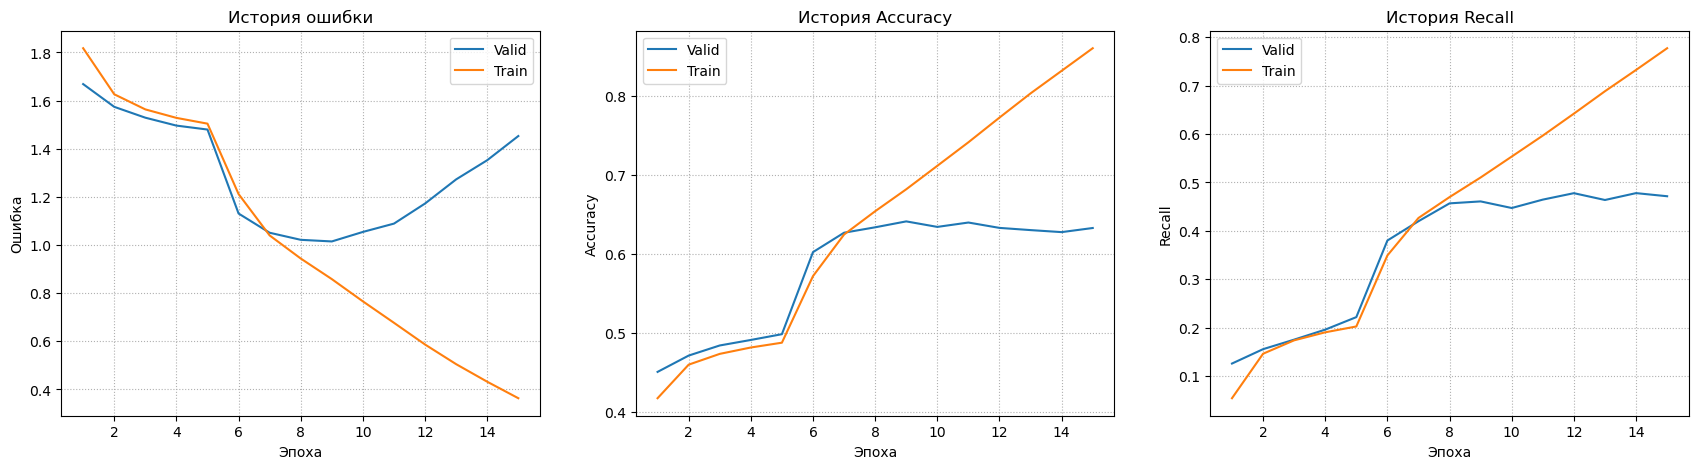

In [19]:
# Training visualisation
t_reader.plot_tensorboard_graphics(0)

In [20]:
# Pytorch lightning
roberta_model = PretrainedDeRoBertaClass.load_from_checkpoint(path_to_checkpoint)
print(deberta_model)
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(roberta_model, val_dataloader)

Some weights of the model checkpoint at ai-forever/ruRoberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

PretrainedDeRoBertaClass(
  (model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(250102, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (dropo

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_acc', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.640997052192688
       test_recall          0.4603413939476013
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.640997052192688, 'test_recall': 0.4603413939476013}]

                     precision    recall  f1-score   support

              Human     0.7758    0.9164    0.8403      8521
             M-BART     0.5302    0.6523    0.5849       417
           M-BART50     0.5224    0.4527    0.4850      1986
            M2M-100     0.4061    0.1764    0.2459      1803
            OPUS-MT     0.3762    0.5348    0.4417      2014
          mT5-Large     0.3408    0.1691    0.2261       810
          mT5-Small     0.4929    0.5653    0.5266       490
       ruGPT2-Large     0.7199    0.6506    0.6835       395
       ruGPT3-Large     0.6552    0.5456    0.5954      1644
      ruGPT3-Medium     0.7465    0.4983    0.5976      1170
       ruGPT3-Small     0.6153    0.7790    0.6876      1154
          ruT5-Base     0.6462    0.6682    0.6570       440
ruT5-Base-Multitask     0.4262    0.1405    0.2114       370
         ruT5-Large     0.2653    0.0448    0.0767       290

           accuracy                         0.6410     21504
          macro avg   

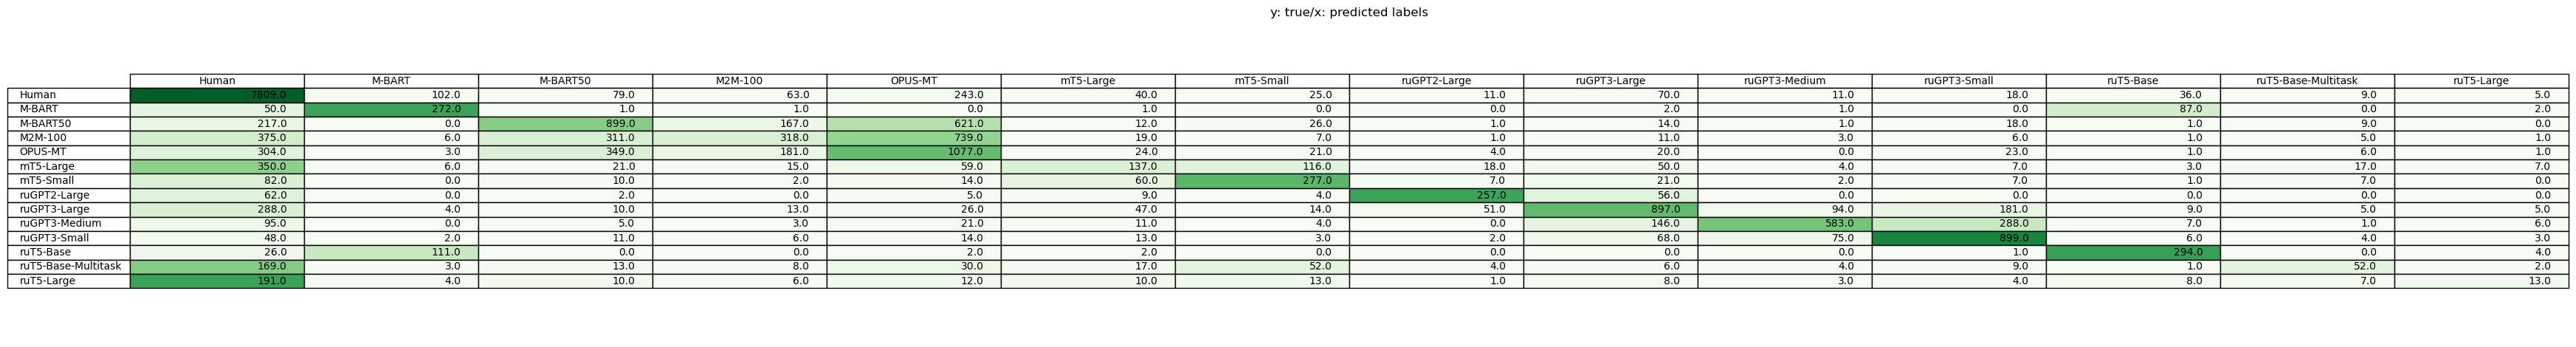

Wrongly predicted examples:
| Record id: | Sentence:                                                                                                                                                                              | True label:         | Pred labels: |
| 201843     | Когда немцы не обеспечены зимним обмундированием, жмутся к населенным пунктам, как к одному своему спасению от лютых морозов, не давать ему возможности обогреваться, пусть замерзает. | ruT5-Large          | ruT5-Base    |
| 90147      | Можно мне задать вопрос?                                                                                                                                                               | M-BART50            | OPUS-MT      |
| 146532     | Лекции по квантовой физики прочитают ученые из ведущих мировых вузов.                                                                                                                  | ruGPT3-Large        | Human        |
| 26160      | Вы выше, 

In [21]:
# Print metrics
stats = Statistics(roberta_model, val_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

### Последний этап
Разметим тестовый набор данных лучшей моделью для участия в соревновании

In [22]:
# Processing test data
test_dataset = CSVDataset(data_config["test_data_path"],
                          is_uncased=data_config["is_uncased"],
                          without_labels=True,
                          pretrained_tokenizer="ai-forever/ruRoberta-large",
                          max_length=data_config["max_token_number"])
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=data_config["batch_size"], drop_last=False)

In [23]:
# Markup of test data
roberta_writer = CSVWriter(roberta_model, test_dataloader, val_dataloader.dataset.index2label)
roberta_writer.write(data_config["pred_data_path"])